In [7]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%cd "/content/drive/MyDrive/Data3461_solutions/Labs/Lab.7/B.FacialVerification"

/content/drive/MyDrive/Data3461_solutions/Labs/Lab.7/B.FacialVerification


# Assignment - 7- B
## Image similarity estimation using a Siamese Network with a triplet loss

## Introduction

A [Siamese Network](https://en.wikipedia.org/wiki/Siamese_neural_network) is a type of network architecture that
contains two or more identical subnetworks used to generate feature vectors for each input and compare them.

Siamese Networks can be applied to different use cases, like detecting duplicates, finding anomalies, and face recognition.

This example uses a Siamese Network with three identical subnetworks. We will provide three images to the model, where
two of them will be similar (_anchor_ and _positive_ samples), and the third will be unrelated (a _negative_ example.)
Our goal is for the model to learn to estimate the similarity between images.

For the network to learn, we use a triplet loss function. You can find an introduction to triplet loss in the
[FaceNet paper](https://arxiv.org/pdf/1503.03832.pdf) by Schroff et al,. 2015. In this example, we define the triplet
loss function as follows:

`L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)`

## Tasks
1. Fetch the data using the following code and create tripets using the helper code. Visualize few random triplets
2. Write a code to preprocess the images. Standard preprocessing includes decoding the image, convert the dtype to float and resizing the image. Use tensorflow functions to do so and store your data in tensorflow variables rather than numpy or python lists as it is much faster.
3. Shuffle the dataset, Split into train and validation. (80-20)
4. Use a pretrained ResNet50 to obtain embeddings for images (freeze the weights). Add few Dense and Batch Norm layers at the end.  Implement triplet loss and train the model. Keep a track of val loss.
5. Now unfreeze last few layers of ResNet50 and rerun the experiment. Compare the val loss of this model with val loss of previous model(with parameters freezed).
6. Use cosine cosine similarity metric to measure how to 2 output embeddings are similar to each other. Is similiarty of  (Anchor , Positive ) > (Anchor , Negative)


## Note -

Change the runtime type to T4 GPU on your colab. Without GPU, the model takes much longer.

## Dataset
* Original Dataset - https://vis-www.cs.umass.edu/lfw/
* Fewer examples from this dataset suitable for our task is selected and is hosted in the following link.

In [9]:
!gdown 1ykjp7xHOE2TSTjcDzm6NlJRP2n_JSaBW

Downloading...
From: https://drive.google.com/uc?id=1ykjp7xHOE2TSTjcDzm6NlJRP2n_JSaBW
To: /content/drive/MyDrive/Data3461_solutions/Labs/Lab.7/B.FacialVerification/LFW_Trimmed_zip.zip
100% 9.45M/9.45M [00:00<00:00, 49.6MB/s]


In [ ]:
!unzip LFW_Trimmed_zip.zip n

Archive:  LFW_Trimmed_zip.zip
caution: filename not matched:  n


In [10]:
image_dir = "LFW_Trimmed"

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from pathlib import Path
import pandas as pd

(250, 250, 3, 3)


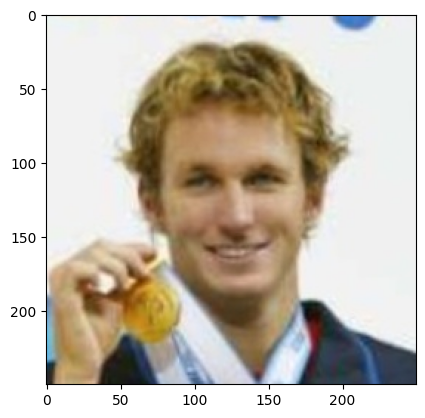

In [12]:
filename = image_dir+"/Aaron_Peirsol/Aaron_Peirsol_0001.jpg"
pixels = plt.imread(filename)

# Show RGB shape
rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print(rgb_pixels.shape)

# Show example image
plt.imshow(pixels)
plt.show()

(250, 250, 3, 3)


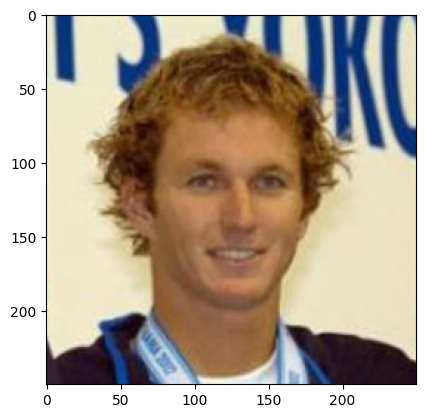

In [13]:
filename = image_dir+"/Aaron_Peirsol/Aaron_Peirsol_0002.jpg"
pixels = plt.imread(filename)

# Show RGB shape
rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print(rgb_pixels.shape)

# Show example image
plt.imshow(pixels)
plt.show()

In [14]:
subjects= os.listdir(image_dir)   # list of all people
image_paths = []
for subject in subjects:
    subject_path = os.path.join(image_dir, subject)
    for filename in os.listdir(subject_path):
        full_path = os.path.join(subject_path, filename)
        image_paths.append(full_path)    # storing path for each and every image in image paths


#photos_list_flatten = [item for sublist in photos_list for item in sublist]
print(len(subjects))
print(subjects[:5])
print(image_paths[:2])

100
['Cameron_Diaz', 'Art_Howe', 'Bernard_Law', 'Aaron_Peirsol', 'Alan_Greenspan']
['LFW_Trimmed/Cameron_Diaz/Cameron_Diaz_0004.jpg', 'LFW_Trimmed/Cameron_Diaz/Cameron_Diaz_0001.jpg']


In [15]:
from itertools import combinations  # imported to create combinations

In [16]:
def create_triplets(subjects, photos_list):    # two images of same person and one image of another person
  anchor_positive=[]
  negative=[]
  for subject in subjects:
    subject_photos= [i for i in photos_list if subject in i]
    non_subjectphotos= [i for i in photos_list if subject not in i]
    anchor_positiveset= list(combinations(subject_photos, 2))
    anchor_positive.extend(anchor_positiveset)
    negative.extend(random.choices(non_subjectphotos, k=len(anchor_positiveset)))
  data_df=pd.DataFrame(anchor_positive,columns=['anchor','positive'])
  data_df['negative']=negative
  return data_df


In [17]:
data_df=create_triplets(subjects,image_paths)  # each column represents anchor, postive and negative image
print(data_df.shape)

(1003, 3)


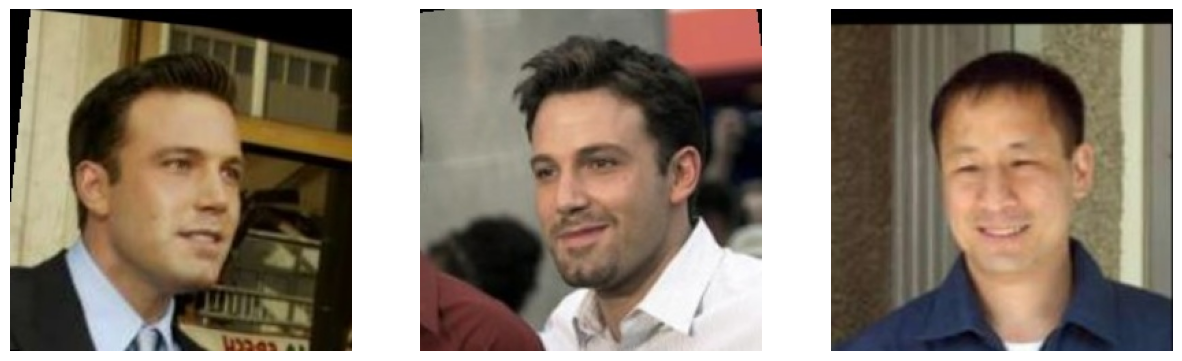

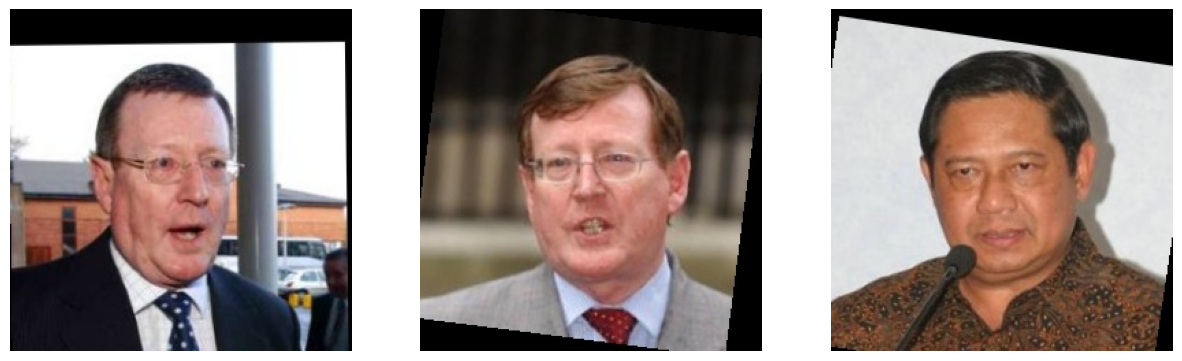

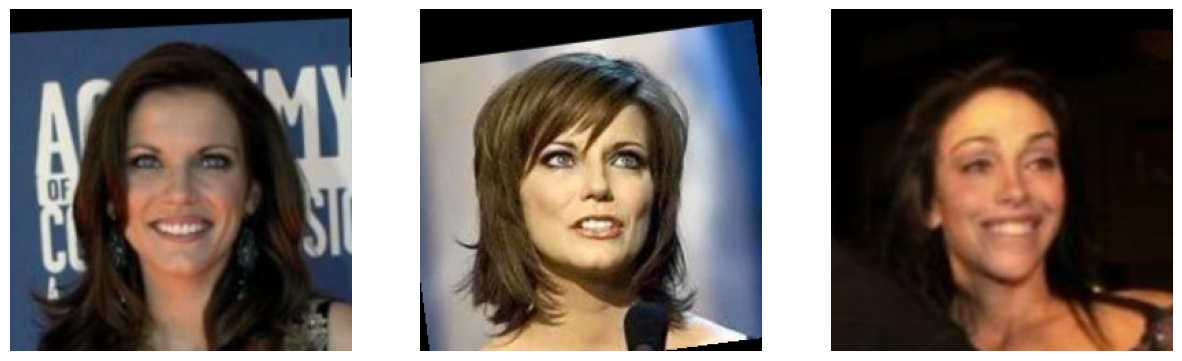

In [18]:
def show_image(file_path):
    image = plt.imread(file_path)
    plt.imshow(image)
    plt.axis('off')

# Randomly select a few triplets to visualize
num_triplets_to_show = 3
triplets_to_show = data_df.sample(n=num_triplets_to_show)

# Visualize each triplet
for _, triplet in triplets_to_show.iterrows():
    plt.figure(figsize=(15, 5))
    for i, role in enumerate(['anchor', 'positive', 'negative']):
        plt.subplot(1, 3, i+1)
        show_image(triplet[role])
    plt.show()

In [23]:
import tensorflow as tf

target_shape = (224, 224)

def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it, and
    resize it to the target shape.
    """
    # Read the image file
    image_string = tf.io.read_file(filename)
    # Decode the image
    image = tf.image.decode_jpeg(image_string, channels=3)
    # Convert the image to floats in the [0, 1] range.
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image
    image = tf.image.resize(image, target_shape)
    return image

def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [24]:
def dataframe_to_dataset(dataframe):
    # Generate dataset
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe['anchor'].values, dataframe['positive'].values, dataframe['negative'].values)
    )
    # Preprocess the dataset
    dataset = dataset.map(preprocess_triplets)
    return dataset

# Use the function to create your dataset
dataset = dataframe_to_dataset(data_df)

# Shuffle the dataset
shuffled_dataset = dataset.shuffle(buffer_size=10000, reshuffle_each_iteration=True)

# Determine the number of elements in the dataset
dataset_size = len(data_df)

# Calculate the number of samples in the training set (80% of the dataset)
train_size = int(0.8 * dataset_size)

# Split the data into train and validation sets
train_dataset = shuffled_dataset.take(train_size)
validation_dataset = shuffled_dataset.skip(train_size)

# Batch the datasets if needed
batch_size = 32  # You can define your own batch size
train_dataset = train_dataset.batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)

# Prefetch the datasets for performance optimization
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [25]:
def show_images(dataset, num_triplets=3):
    # Take 'num_triplets' examples from the dataset
    for triplet_batch in dataset.take(num_triplets):
        anchor_batch, positive_batch, negative_batch = triplet_batch

        # Iterate through each triplet in the batch
        for i in range(anchor_batch.shape[0]):  # assuming the batch size is the first dimension
            anchor_image = anchor_batch[i].numpy()
            positive_image = positive_batch[i].numpy()
            negative_image = negative_batch[i].numpy()

            # Plot the triplet images
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(anchor_image)
            plt.title("Anchor")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(positive_image)
            plt.title("Positive")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(negative_image)
            plt.title("Negative")
            plt.axis('off')

            plt.show()

show_images(train_dataset)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model



# Load ResNet50 with pre-trained ImageNet weights
base_cnn = ResNet50(weights="imagenet", input_shape=target_shape + (3,), include_top=False)

# Freeze all layers in the base CNN
for layer in base_cnn.layers:
    layer.trainable = False

# Add new layers on top of the CNN
flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
bn1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(bn1)
bn2 = layers.BatchNormalization()(dense2)
output = layers.Dense(252)(bn2)
# Create the new model
embedding = Model(inputs=base_cnn.input, outputs=output, name="Embedding")

In [27]:
# Define the triplet loss function
def triplet_loss(y_true, y_pred, alpha = 0.2):
    vector_length = y_pred.shape[1]

    if vector_length % 3 != 0:
        raise ValueError("The size of the embedding vector should be divisible by 3")

    # Split the embeddings into anchor, positive and negative
    anchor, positive, negative = tf.split(y_pred, num_or_size_splits=3, axis=1)
    positive_distance = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    negative_distance = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    loss = tf.maximum(positive_distance - negative_distance + alpha, 0.0)
    return tf.reduce_mean(loss)

In [ ]:
# Compile the model
embedding.compile(optimizer='adam', loss=triplet_loss)

# Train the model
history = embedding.fit(train_dataset, epochs=10, validation_data=validation_dataset)

val_loss = history.history['val_loss']

Epoch 1/10
26/26 [==============================] - ETA: 0s - loss: 0.2048

26/26 [==============================] - 31s 438ms/step - loss: 0.2048 - val_loss: 0.0000e+00
Epoch 2/10
25/26 [===========================>..] - ETA: 0s - loss: 1.9388e-04

26/26 [==============================] - 14s 400ms/step - loss: 1.9340e-04 - val_loss: 0.0000e+00
Epoch 3/10
25/26 [===========================>..] - ETA: 0s - loss: 0.0000e+00

26/26 [==============================] - 16s 388ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
25/26 [===========================>..] - ETA: 0s - loss: 0.0000e+00

26/26 [==============================] - 17s 524ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
25/26 [===========================>..] - ETA: 0s - loss: 0.0000e+00

26/26 [==============================] - 17s 524ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
25/26 [===========================>..] - ETA: 0s - loss: 0.0000e+00

26/26 [==============================] - 14s 380ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
25/26 [===========================>..] - ETA: 0s - loss: 0.0000e+00

26/26 [==============================] - 13s 317ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/10
25/26 [===========================>..] - ETA: 0s - loss: 0.0000e+00

26/26 [==============================] - 18s 533ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/10
25/26 [===========================>..] - ETA: 0s - loss: 0.0000e+00

In [1]:
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))


distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

NameError: ignored

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
# Create an instance of SiameseModel with the siamese_network
siamese_model = SiameseModel(siamese_network)

# Compile the SiameseModel instance
siamese_model.compile(optimizer='adam')

# Initial training with frozen ResNet50 layers
history_initial = siamese_model.fit(train_dataset, epochs=5, validation_data=validation_dataset)
initial_val_loss = history_initial.history['val_loss']

# Unfortunately my code is crashing during this training T.T

In [ ]:
# Recompile the Siamese model with unfrozen layers
siamese_model.compile(optimizer='adam', loss=triplet_loss)

# Fine-tune the Siamese network
history_finetuned = siamese_model.fit(train_dataset, epochs=5, validation_data=validation_dataset)

# Get the validation loss after fine-tuning
finetuned_val_loss = history_finetuned.history['val_loss']

In [ ]:
# Compare the validation losses
print("Initial Training Validation Loss:", initial_val_loss)
print("Fine-Tuned Training Validation Loss:", finetuned_val_loss)

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=5, validation_data=val_dataset)

In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())